# Este notebook trata da importação do dataframe que servirá de base para os modelos de aprendizagem de máquina e está dividido da seguinte forma:
## 1 - Importa dados da TEC (TEC.csv)
## 2 - Analisa e processa coluna 'ncm'
## 3 - Cria funções auxiliares para o processamento da coluna descrição
## 4 - Analisa e processa coluna 'descricao'
## 5 - Cria a coluna 'descricao_limpa'
## 6 - Cria a coluna 'descricao_limpa_sem_stopwords'
## 7 - Cria a coluna 'descricao_limpa_stemming'
## 8 - Cria a coluna 'descricao_limpa_sem_stopwords_stemming'

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import unicodedata
import re

import nltk
from nltk.stem import RSLPStemmer
import operator

from collections import Counter, defaultdict
from wordcloud import WordCloud

import sys
sys.path.append('..')
import extras.processtec as pt


## 1 - Importa dados da TEC

In [2]:
tec = pd.read_csv('../data/TEC.csv', )

## 1.1 - Extrai informações do dataframe:
###    - tamanho 10147 linhas
###    - colunas: 
###        'descricao' - 10147 valores não nulos, tipo Object
###        'ncm' - 10147 valores não nulos, tipo float64

In [3]:
len(tec)

10147

In [4]:
tec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   descricao  10147 non-null  object 
 1   ncm        10147 non-null  float64
dtypes: float64(1), object(1)
memory usage: 158.7+ KB


In [5]:
tec.describe()

,ncm
count,1.014700e+04
mean,5.077591e+07
std,2.764826e+07
min,1.012100e+06
25%,2.921437e+07
50%,4.410191e+07
75%,8.412595e+07
max,9.706000e+07


In [6]:
tec.head()

,descricao,ncm
0,Reprodutores de raca pura Cavalos Cavalos as...,1012100.0
1,Outros Cavalos Cavalos asininos e muares vi...,1012900.0
2,Asininos Cavalos asininos e muares vivos,1013000.0
3,Outros Cavalos asininos e muares vivos,1019000.0
4,Prenhes ou com cria ao pe Reprodutores de raca...,1022110.0


## 2 - Analisa e processa coluna "ncm"

## 2.1 - Análise de dados não numéricos e campos vazios. Tenta transformar valores em float, o que falhar transformar em 'NaN' para depois excluir

In [7]:
# tenta transformar em float, se não conseguir marca como NaN
for i, value in enumerate(tec.ncm):
    try:
        float(value)
    except Exception:
        tec.ncm[i] = float('NaN')

In [8]:
# quantidade de itens faltantes na coluna ncm
sum(tec.ncm.isna())

0

In [9]:
# apaga todas as linhas do dataframe onde 
# o valor da coluna ncm é valor faltante
tec = tec.dropna(subset=['ncm'])

In [10]:
# tamanho do dataframe após remoção
# dos valores faltantes
len(tec)

10147

## 2.2 - Transforma valores em números inteiros, converte para string e preenche os zeros a esquerda de modo a termos 8 caracteres no total.

In [11]:
tec['ncm_str'] = tec.ncm.astype(float).astype(int).astype(str)
tec['ncm_str'] = tec.ncm_str.str.zfill(8)  # preenche zeros a esquerda de modo a termos 8 caracteres no final

## 2.3 Cria colunas "capitulo", "posicao", "subposicao", "item" e "subitem" -

In [12]:
# os dois primeiros dígitos da NCM
tec['capitulo'] = tec.ncm_str.str[:2]

In [13]:
# terceiro e quarto dígitos da NCM
tec['posicao'] = tec.ncm_str.str[2:4]

In [14]:
# quinto e sexto dígito da NCM
tec['subposicao'] = tec.ncm_str.str[4:6]

In [15]:
# sétimo dígito da NCM
tec['item'] = tec.ncm_str.str[6]

In [16]:
# oitavo dígito da NCM
tec['subitem'] = tec.ncm_str.str[7]

In [17]:
# apaga se tiver capitulo '00'
tec = tec.drop(tec[tec['capitulo'] == '00'].index)

In [18]:
len(tec)

10147

## 2.4 - Análise estatística da coluna 'capítulo'.

### 2.4.1 Cria dicionário contendo o somatório total de cada capítulo

In [19]:
# cira dicionário com somatório total de itens na coluna
capitulos = {}
for value in tec.capitulo:
    if capitulos.get(value):
        capitulos[value] += 1
    else:
        capitulos[value] = 1

### 2.4.2 ordena do capítulos em ordem decrescente de quantidade

In [20]:
# ordena dicionário em ordem decrescente de quantidade
capitulos = dict(sorted(capitulos.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(capitulo, qtidd) for capitulo, qtidd in capitulos.items() if qtidd > 200]

[('29', 1519),
 ('84', 1116),
 ('85', 649),
 ('28', 409),
 ('30', 401),
 ('90', 367),
 ('03', 320),
 ('39', 313),
 ('38', 259),
 ('72', 212)]

### 2.4.3 Gráfico de barras da quantidade de capítulos

Text(0, 0.5, 'Quantidade')

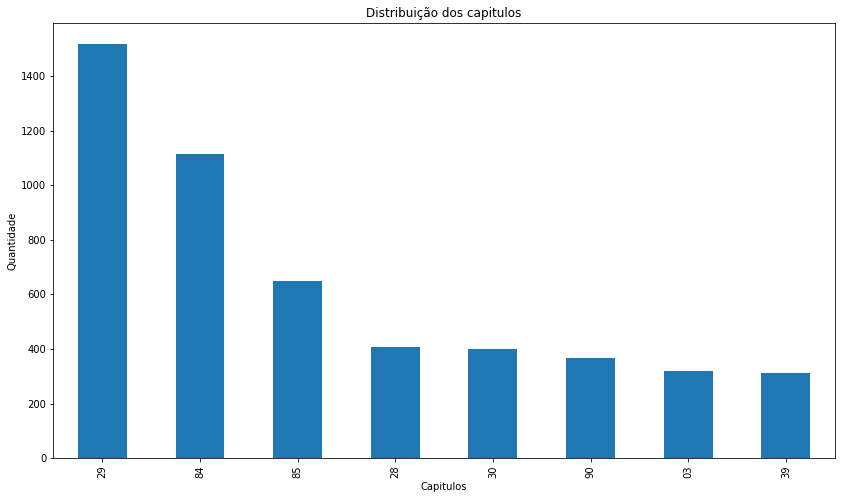

In [21]:
# Cria gráfico de barras
values = tec['capitulo'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 300  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")

## Conclusão - Como se trata da estrutura oficial da NCM, essa análise de distribuição é apenas didática, no qual os capítulos com maiores quantidade de descrições são "29", "84" e "85", "28", "30", "90", "03", "39".
## Como era esperado, não há registro para o Capítulo 77 pois ele é reservado para uma eventual utilização futura no Sistema Harmonizado.

## 2.5 - Análise estatística da coluna 'posicao'.

In [22]:
# cira dicionário com somatório total de itens na coluna
posicao = {}
for value in tec.posicao:
    if posicao.get(value):
        posicao[value] += 1
    else:
        posicao[value] = 1
        
# ordena dicionário em ordem decrescente de quantidade
posicao = dict(sorted(posicao.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(item,qtidd) for item, qtidd in posicao.items() if qtidd > 295]

[('04', 771),
 ('02', 758),
 ('03', 730),
 ('01', 506),
 ('07', 481),
 ('06', 465),
 ('05', 462),
 ('08', 436),
 ('09', 343),
 ('10', 297)]

Text(0, 0.5, 'Quantidade')

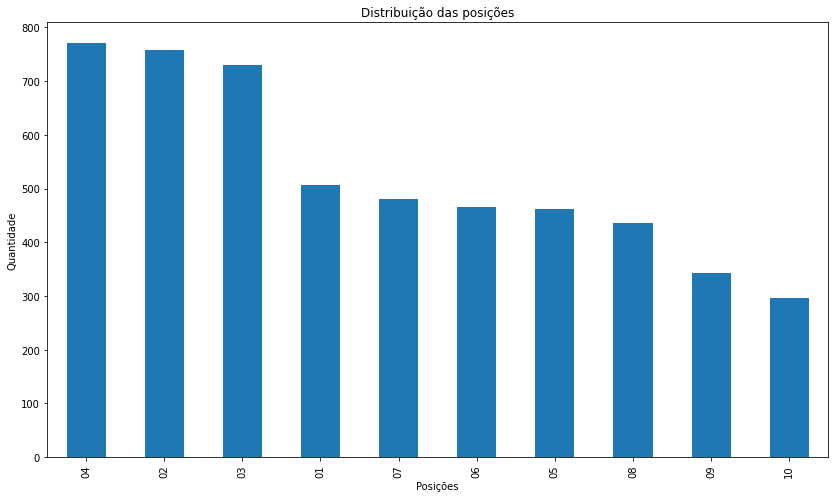

In [23]:
# Cria gráfico de barras
values = tec['posicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 295  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")

## Conclusão - Considerando que temos 5968 itens na coluna 'posicao', os com maior representatividade (quantidade maior que 100 itens) são: 04, 02, 03, 01, 07 06 ,05, 08, 09, 10

## 2.6 - Análise estatística da coluna 'subposicao'.

In [24]:
# cira dicionário com somatório total de itens na coluna
subposicao = {}
for value in tec.subposicao:
    if subposicao.get(value):
        subposicao[value] += 1
    else:
        subposicao[value] = 1

# ordena dicionário em ordem decrescente de quantidade
subposicao = dict(sorted(subposicao.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(item,qtidd) for item, qtidd in subposicao.items() if qtidd > 300]

[('90', 1390),
 ('10', 981),
 ('20', 735),
 ('00', 490),
 ('30', 470),
 ('19', 455),
 ('99', 436),
 ('29', 385),
 ('11', 348),
 ('39', 331)]

Text(0, 0.5, 'Quantidade')

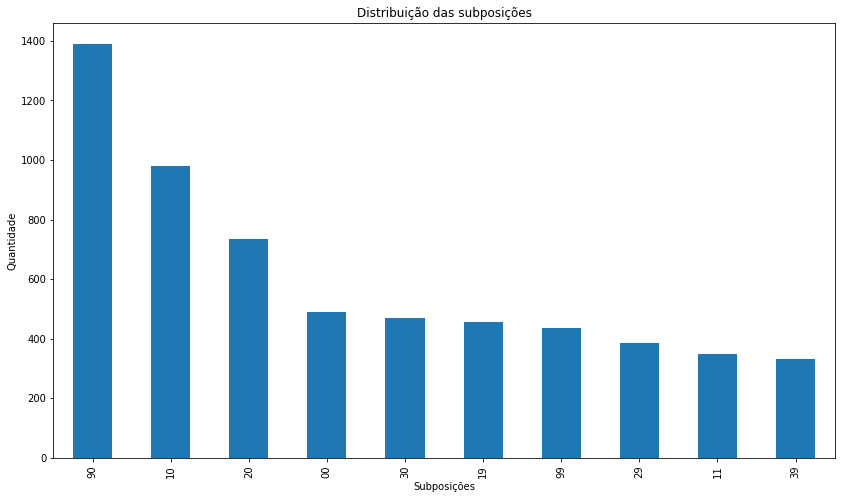

In [25]:
# Cria gráfico de barras
values = tec['subposicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 300  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das subposições")
ax.set_xlabel("Subposições")
ax.set_ylabel("Quantidade")

## Conclusão - Considerando que temos 5968 itens na coluna 'subposicao', os com maior representatividade (quantidade maior que 100 itens) são: 90, 10, 20, 00, 30, 19, 99.

## 2.7 - Análise estatística das colunas 'item' e 'subitem'.

Text(0, 0.5, 'Quantidade')

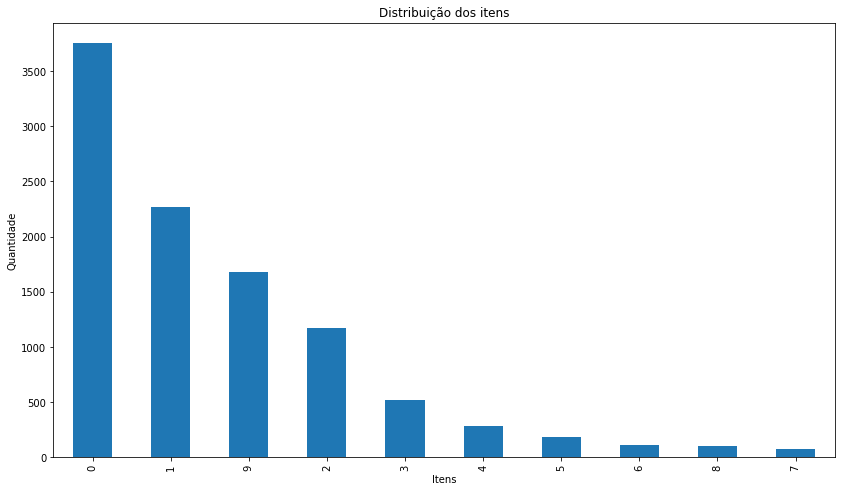

In [26]:
# Cria gráfico de barras
values = tec['item'].value_counts()  # conta quantidade de valores da coluna capítulo

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos itens")
ax.set_xlabel("Itens")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

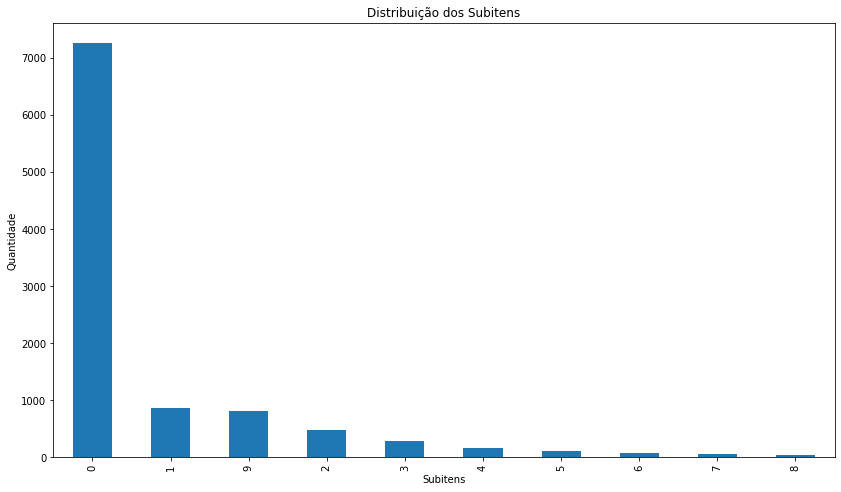

In [27]:
# Cria gráfico de barras
values = tec['subitem'].value_counts()  # conta quantidade de valores da coluna capítulo

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos Subitens")
ax.set_xlabel("Subitens")
ax.set_ylabel("Quantidade")

## Conclusão: a frequencia do 0 tanto em item como em subitem é muito maior do que os outros números.

## 2.8 Capítulos Faltantes:

In [28]:
print(f'O dataframe itens não contém o(s) capitlo(s):')
for i in range(96):
    if len(tec[tec['capitulo'] == str(i+1).zfill(2)]) == 0:
        print(f'{str(i+1).zfill(2)}', end=' ')

O dataframe itens não contém o(s) capitlo(s):
77 

## 3 - Cria funções que serão úteis para o processamento do texto do dataframe

## 3.1 - Função que remove sinais de pontuação e espaços

In [29]:
def remove_accents(input_str):  
    """ 
    Função converte string em bytes, mas antes normaliza string usando NFKD
    
    NFKD - decompõem em dois code point e analisa compatibilidades (sem ser canonicamente equivalente)
    https://docs.python.org/3/library/unicodedata.html
    """
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

## 3.2 - Função que retorna somente o radical da palavra passada como parâmetro

In [30]:
st = RSLPStemmer()
def stem_word(word):
    aux = word
    if aux != b'':
        aux = st.stem(aux.decode("utf-8"))  # pega o radical das palavras
        aux = str.encode(aux)
    return aux

## 3.3 - Função que verifica se é CPF ou CNPJ

In [31]:
def cpf_ou_cnpj(string):
    if re.search(
         "^([0-9]{2}[\.]?[0-9]{3}[\.]?[0-9]{3}[\/]?[0-9]{4}[-]?[0-9]{2})|([0-9]{3}[\.]?[0-9]{3}[\.]?[0-9]{3}[-]?[0-9]{2})$",
         string):
        return True
    return False    

## 3.4 - Função que processa o texto:
## a) convertendo para minúsculo
## b) removendo sinais de pontuação, 
## c) removendo sinais ortográficos,
## d) remove CPF e CNPJ,
## e) removendo stopwords (opcional), 
## f) retorna radicais das palavras - stemming (opcional)

In [32]:
def cria_coluna_descricao(dataframe, col_origem, col_destino, stop_words, stemming=False):
    num_words = Counter()
    word_count = Counter()
    times = 0
    novas_linhas = []
    col_index = dataframe.columns.get_loc(col_origem) + 1 

    for linha in dataframe.itertuples():  # para cada linha do dataframe
        lista_linha = re.split('\W+', linha[col_index].strip())  # exclui sinais de pontuação, inclusive espaços
        num_words[len(lista_linha)]+=1  # atualiza contador de quantidade de palavras
        nova_linha = []
        for word in lista_linha:
            word = word.lower()
            if word not in stop_words:  #verifica se não está nos stopword
                # verifica se não é CPF ou CNPJ
                 if not cpf_ou_cnpj(word):
                    word = remove_accents(word)  # remove acentuação
                    if stemming:
                        word = stem_word(word)  # retorna somente o radical da palavra 
                    word_count[word]+=1  # atualiza contador de palavras
                    nova_linha.append(word.decode().strip())
        if len(nova_linha) >= 0:
            novas_linhas.append(' '.join(nova_linha))
    
    dataframe[col_destino] = novas_linhas  # cria nova coluna do dataframe com as palavras limpas
    return num_words, word_count

## 4 - Analisa e processa coluna 'descricao', que servirá para criação do vocabulário

## 4.1 Lista de stopwords da biblioteca nltk

In [33]:
stopwords = nltk.corpus.stopwords.words('portuguese')
len(stopwords)
# [stopwords.append(_) for _ in stop_words_itens]
# stopwords = list(set(stopwords))  # apaga repetidas 
# print(len(stopwords))

204

## 5 - Cria a coluna 'descricao_limpa'
## 5.1 - Nessa coluna não foram retiradas as stopwords e também não foram retirados os afixos 

In [34]:
# cria a coluna descricao_limpa sem informar nenhuma stopword e sem fazer o stemming
num_words, word_count = cria_coluna_descricao(tec, 'descricao', 'descricao_limpa', "")

In [35]:
# compara item da coluna descricao com a descricao_limpa dele
tec.loc[8].descricao, tec.loc[8].descricao_limpa

('Outros Outros Bovinos domesticos  Animais vivos da especie bovina ',
 'outros outros bovinos domesticos animais vivos da especie bovina')

In [36]:
# 20 palavras mais comuns (com maior freq acumulada)
word_count.most_common(20)

[(b'de', 28695),
 (b'e', 15897),
 (b'ou', 15852),
 (b'outros', 9210),
 (b'para', 7632),
 (b'a', 5423),
 (b'nao', 4372),
 (b'em', 4265),
 (b'outras', 3485),
 (b'aparelhos', 3466),
 (b'os', 3262),
 (b'seus', 3007),
 (b'incluindo', 2705),
 (b'produtos', 2635),
 (b'mesmo', 2530),
 (b'por', 2527),
 (b'com', 2425),
 (b'exceto', 2397),
 (b'maquinas', 2303),
 (b'que', 2092)]

## 5.2 - Nuvem de palavras - 50 palavras mais frequentes

In [37]:
# cria um dicionário temporário 'text' com as 50 palavras mais frequentes
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [38]:
# cria a nuvem de palavras
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

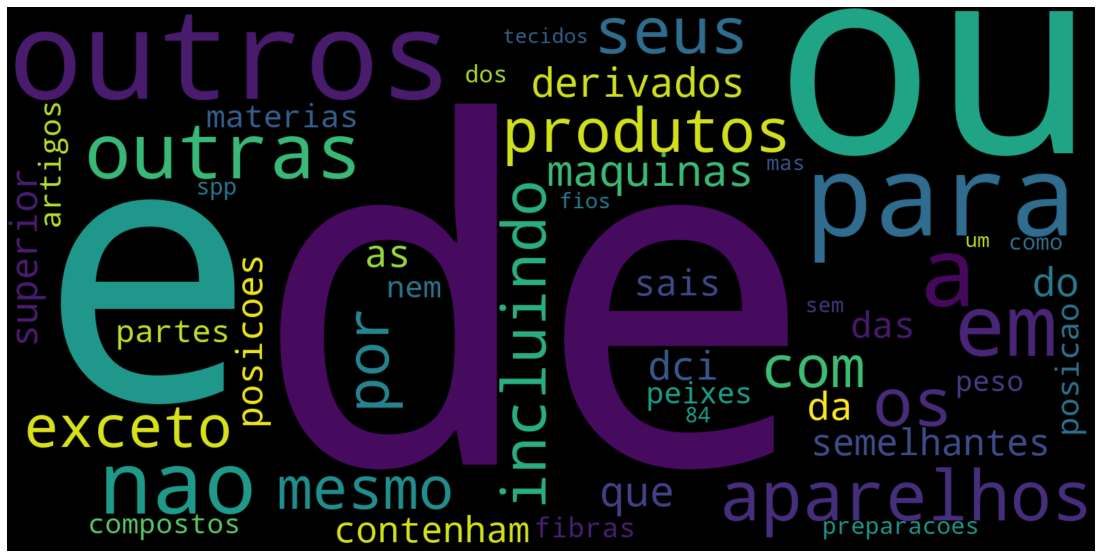

In [39]:
# configurações de plotagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [40]:
# Cria dataframe com as 50 palavras mais frequentes
df_word_count = pd.DataFrame()
df_word_count['descricao_limpa'] = text.keys()
df_word_count.head(10)

,descricao_limpa
0,de
1,e
2,ou
3,outros
4,para
5,a
6,nao
7,em
8,outras
9,aparelhos


### Conclusão: Pelo fato de não termos retirado as stopwords, as palavras mais frequentes foram "de", "ou" e "outros",  "outras", "para" que são palavras que não agregam nada na classificação pois elas podem estar na descrição de diferentes NCMs

## 5.3 - Salva dataframe em formato parquet

In [41]:
tec.to_parquet('2_tec_desc_limpa.parquet')  # salva em formato parquet

## 6 - Cria a coluna 'descricao_limpa_sem_stopwords'
## 6.1 - Nessa coluna foram retiradas as stopwords para termos descrições com palavras mais importantes. 
## Não foram retirados os afixos 

In [42]:
num_words, word_count = cria_coluna_descricao(tec, 'descricao', 'descricao_limpa_sem_stopwords', stopwords)

In [43]:
tec.loc[8].descricao, tec.loc[8].descricao_limpa_sem_stopwords

('Outros Outros Bovinos domesticos  Animais vivos da especie bovina ',
 'outros outros bovinos domesticos animais vivos especie bovina')

In [44]:
word_count.most_common(20)

[(b'outros', 9210),
 (b'nao', 4372),
 (b'outras', 3485),
 (b'aparelhos', 3466),
 (b'incluindo', 2705),
 (b'produtos', 2635),
 (b'exceto', 2397),
 (b'maquinas', 2303),
 (b'derivados', 1941),
 (b'dci', 1841),
 (b'superior', 1628),
 (b'semelhantes', 1568),
 (b'contenham', 1530),
 (b'sais', 1512),
 (b'posicoes', 1491),
 (b'posicao', 1174),
 (b'partes', 1169),
 (b'materias', 1162),
 (b'artigos', 1060),
 (b'peixes', 1024)]

## 6.2 - Nuvem de palavras - 50 palavras mais frequentes

In [45]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [46]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

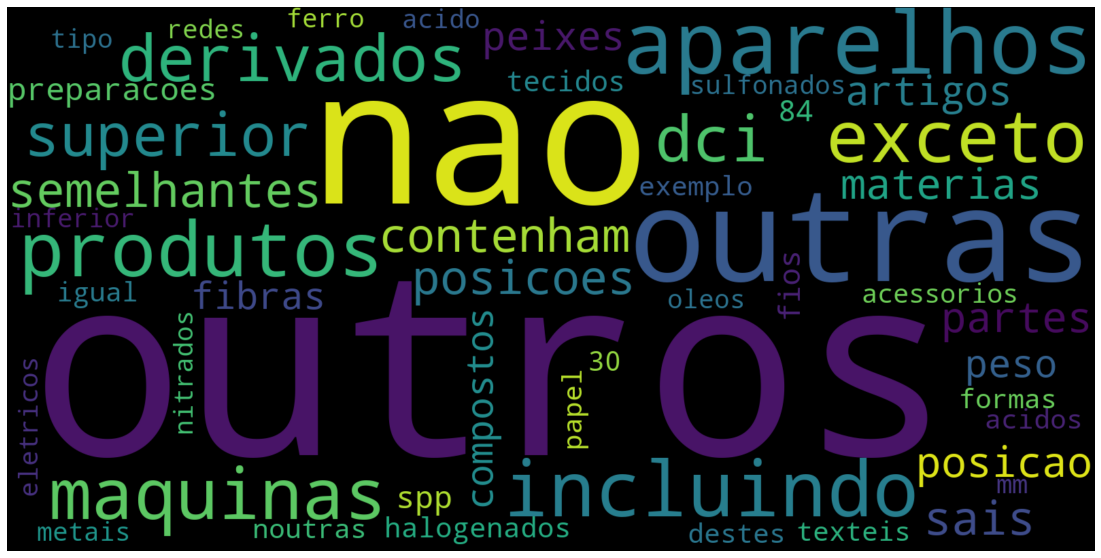

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [48]:
df_word_count['descricao_limpa_sem_stopwords'] = text.keys()
df_word_count.head(10)

,descricao_limpa,descricao_limpa_sem_stopwords
0,de,outros
1,e,nao
2,ou,outras
3,outros,aparelhos
4,para,incluindo
5,a,produtos
6,nao,exceto
7,em,maquinas
8,outras,derivados
9,aparelhos,dci


### Conclusão: a retirada de stopwords melhorou aparentemente a distribuição das palavras na descrição.

## 6.3 - Salva dataframe em formato parquet

In [49]:
tec.to_parquet('2_tec_desc_limpa_sem_stopwords.parquet')  # salva em formato parquet

## 7 - Cria a coluna 'descricao_limpa_stemming'
## 7.1 - Nessa coluna não foram retiradas as stopwords 
## Mas foram retirados os afixos, mantendo somente o radical das palavras

In [50]:
num_words, word_count = cria_coluna_descricao(tec, 'descricao', 'descricao_limpa_stemming', "", True)

In [51]:
tec.loc[8].descricao, tec.loc[8].descricao_limpa_stemming

('Outros Outros Bovinos domesticos  Animais vivos da especie bovina ',
 'outr outr bovin domes animal viv da especi bovin')

In [52]:
word_count.most_common(20)

[(b'de', 28695),
 (b'e', 15897),
 (b'ou', 15852),
 (b'outr', 13527),
 (b'par', 7632),
 (b'a', 5423),
 (b'nao', 4372),
 (b'em', 4265),
 (b'aparelh', 3584),
 (b'com', 3367),
 (b'os', 3262),
 (b'da', 3229),
 (b'seu', 3151),
 (b'do', 2768),
 (b'inclu', 2716),
 (b'produt', 2646),
 (b'mesm', 2573),
 (b'por', 2568),
 (b'excet', 2397),
 (b'maquin', 2346)]

## 7.2 - Nuvem de palavras - 50 palavras mais frequentes

In [53]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [54]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

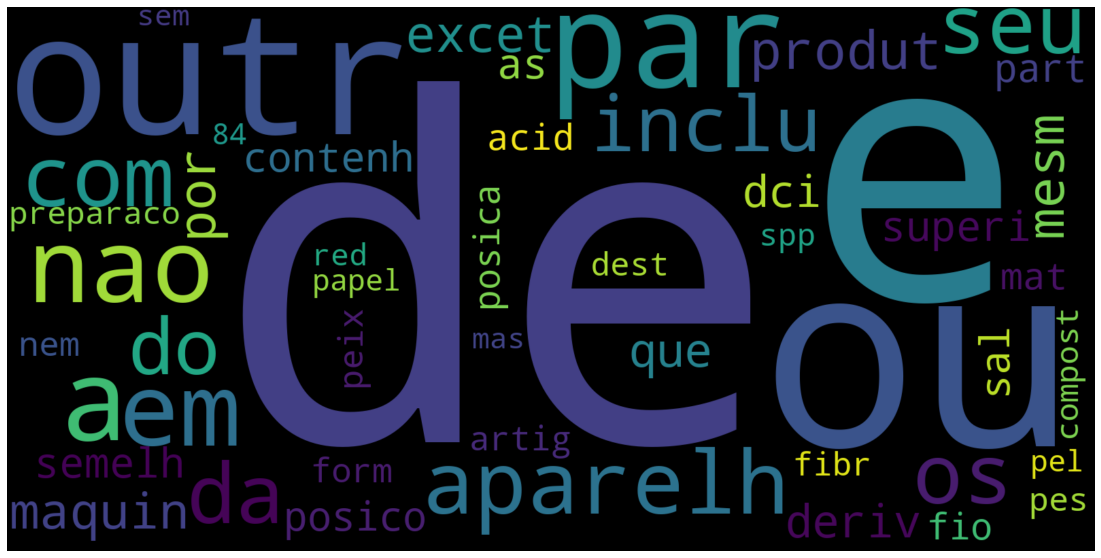

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [56]:
df_word_count['descricao_limpa_stemming'] = text.keys()
df_word_count.head(10)

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_stemming
0,de,outros,de
1,e,nao,e
2,ou,outras,ou
3,outros,aparelhos,outr
4,para,incluindo,par
5,a,produtos,a
6,nao,exceto,nao
7,em,maquinas,em
8,outras,derivados,aparelh
9,aparelhos,dci,com


### Conclusão: ainda há o problema das stopwords. isso pode melhorar a acurácia do modelo.

# obs: esse dataframe não será utilizado como dado de entrada do modelo

## 7.3 - Salva dataframe em formato parquet

In [57]:
tec.to_parquet('2_tec_desc_limpa_stemming.parquet')  # salva em formato parquet

## 8 - Cria a coluna 'descricao_limpa_sem_stopwords_stemming'
## 8.1 - Nessa coluna foram retiradas as stopwords e os afixos

In [58]:
num_words, word_count = cria_coluna_descricao(tec, 'descricao', 'descricao_limpa_sem_stopwords_stemming', stopwords, True)

In [59]:
tec.loc[8].descricao, tec.loc[8].descricao_limpa_sem_stopwords_stemming

('Outros Outros Bovinos domesticos  Animais vivos da especie bovina ',
 'outr outr bovin domes animal viv especi bovin')

In [60]:
word_count.most_common(20)

[(b'outr', 13527),
 (b'nao', 4372),
 (b'aparelh', 3584),
 (b'inclu', 2716),
 (b'produt', 2646),
 (b'excet', 2397),
 (b'maquin', 2346),
 (b'deriv', 1967),
 (b'dci', 1841),
 (b'superi', 1651),
 (b'semelh', 1634),
 (b'sal', 1585),
 (b'contenh', 1565),
 (b'posico', 1491),
 (b'part', 1365),
 (b'mat', 1289),
 (b'fio', 1241),
 (b'acid', 1212),
 (b'posica', 1174),
 (b'peix', 1079)]

## 8.2 - Nuvem de palavras - 50 palavras mais frequentes

In [61]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [62]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

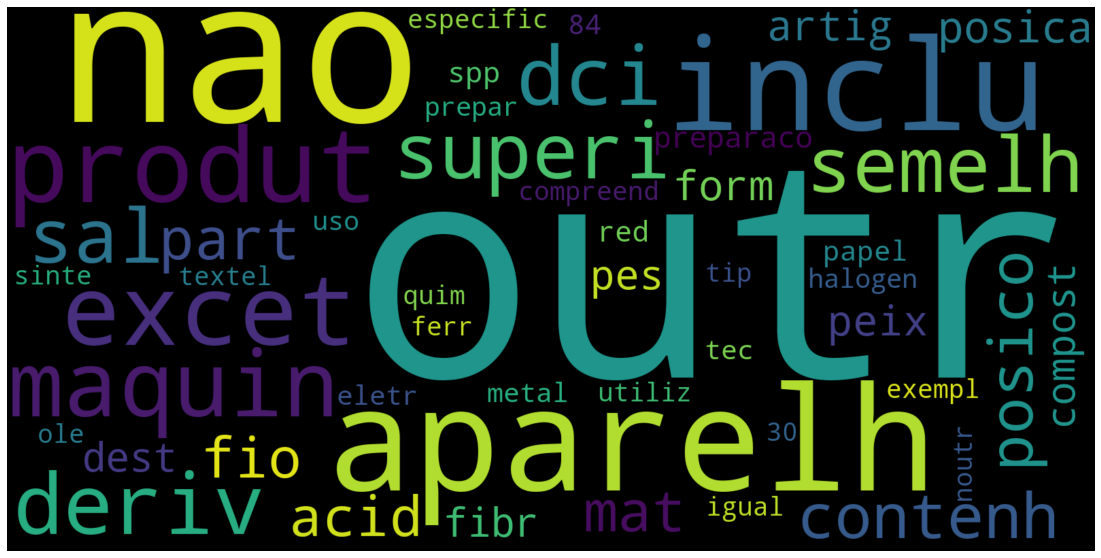

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [64]:
df_word_count['descricao_limpa_sem_stopwords_stemming'] = text.keys()

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_stemming,descricao_limpa_sem_stopwords_stemming
0,de,outros,de,outr
1,e,nao,e,nao
2,ou,outras,ou,aparelh
3,outros,aparelhos,outr,inclu
4,para,incluindo,par,produt
5,a,produtos,a,excet
6,nao,exceto,nao,maquin
7,em,maquinas,em,deriv
8,outras,derivados,aparelh,dci
9,aparelhos,dci,com,superi


In [65]:
df_word_count = df_word_count.drop('descricao_limpa_stemming', 1)

In [66]:
df_word_count.head(20)

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_sem_stopwords_stemming
0,de,outros,outr
1,e,nao,nao
2,ou,outras,aparelh
3,outros,aparelhos,inclu
4,para,incluindo,produt
5,a,produtos,excet
6,nao,exceto,maquin
7,em,maquinas,deriv
8,outras,derivados,dci
9,aparelhos,dci,superi


### Conclusão: retirando as stopwords e pegando apenas os radicais temos uma base de palavras melhor para utilizar na classificação

## 8.3 - Salva dataframe em formato parquet

In [67]:
tec.to_parquet('2_tec_desc_limpa_sem_stopwords_stemming.parquet')  # salva em formato parquet